In [36]:
# Mount drive first and proceed
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
import os
print(os.listdir('/content/gdrive/MyDrive/Project 4/Combined flowers'))

['daffodil', 'orchid', 'tulip', 'hydrangea', 'hibiscus', 'rose', 'dahlia', 'foxglove', 'sunflower', 'bougainvillea', 'data.npy', 'label.npy']


In [38]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [49]:
X = np.load('/content/gdrive/MyDrive/Project 4/Combined flowers/data.npy')
X=X/255
label = np.load('/content/gdrive/MyDrive/Project 4/Combined flowers/label.npy')

In [50]:
print(len(X))
print(len(label))

3129
3129


In [51]:

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(label)
y = to_categorical(y, 10)

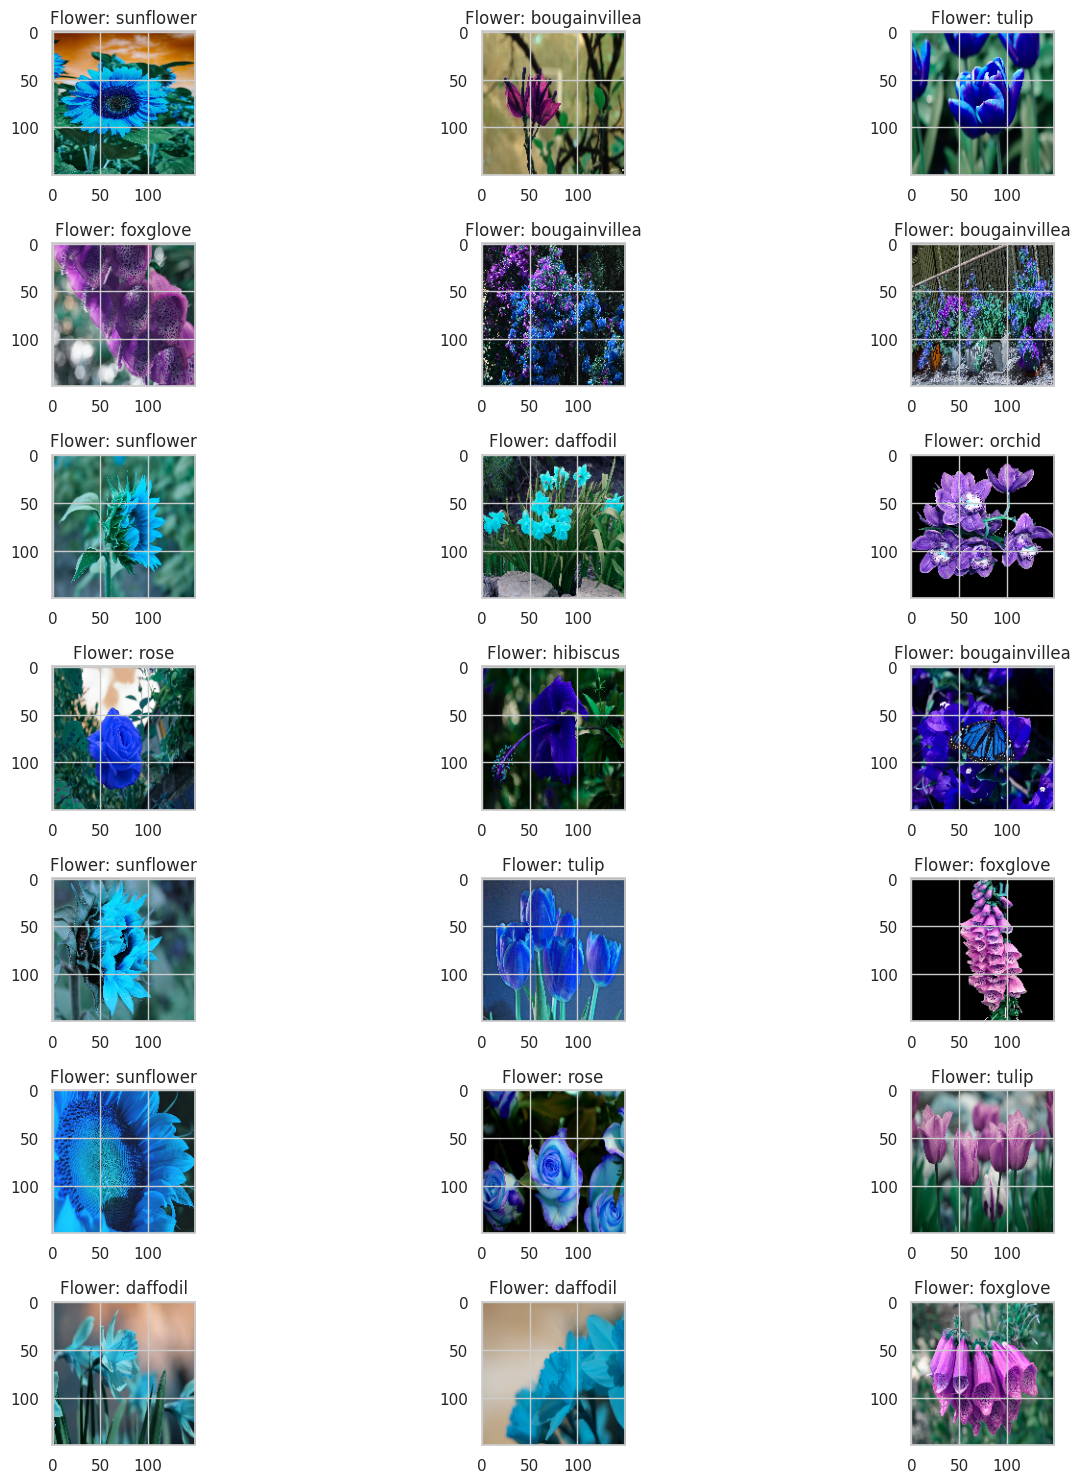

In [52]:
f,ax = plt.subplots(7,3)
f.set_size_inches(15,15)
for i in range(7):
    for j in range(3):
        l = rn.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title("Flower: " + label[l])
plt.tight_layout()

In [48]:
print(X[0])

[[[ 30  50  55]
  [ 32  54  59]
  [ 30  54  60]
  ...
  [ 52  89 109]
  [ 53  88 108]
  [ 54  94 113]]

 [[ 32  54  57]
  [ 30  54  59]
  [ 33  58  63]
  ...
  [ 52  85 105]
  [ 59  95 113]
  [ 60  95 115]]

 [[ 24  45  48]
  [ 29  53  59]
  [ 33  58  62]
  ...
  [ 60  92 111]
  [ 67  98 118]
  [ 66  96 116]]

 ...

 [[ 67  62  27]
  [ 49  41   4]
  [ 26  40   4]
  ...
  [ 10  18   1]
  [  0  12   0]
  [  0  14   0]]

 [[131  84  31]
  [ 58  51   3]
  [ 36  43  10]
  ...
  [ 17  22   1]
  [  0  12   0]
  [  0  14   0]]

 [[ 59  53  21]
  [ 72  67  34]
  [ 43  47   6]
  ...
  [ 16  21   0]
  [  0  12   0]
  [  0  14   0]]]


In [53]:
# Split the data into training and testing sets

train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the arrays to verify the loading process
print("Train Images shape:", train_images.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Images shape:", test_images.shape)
print("Test Labels shape:", test_labels.shape)

Train Images shape: (2503, 150, 150, 3)
Train Labels shape: (2503, 10)
Test Images shape: (626, 150, 150, 3)
Test Labels shape: (626, 10)


In [54]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [58]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150, 150,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [59]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [61]:
# Train the model
batch_size = 32
epochs = 50

History = model.fit_generator(datagen.flow(train_images,train_labels, batch_size=batch_size),
                              epochs = epochs, validation_data = (test_images,test_labels),
                              verbose = 1, steps_per_epoch=test_images.shape[0] // batch_size)

Epoch 1/50
19/19 [==============================] - 101s 5s/step - loss: 1.9155 - accuracy: 0.2566 - val_loss: 1.8392 - val_accuracy: 0.3147
Epoch 2/50
19/19 [==============================] - 61s 3s/step - loss: 1.8133 - accuracy: 0.3438 - val_loss: 1.7158 - val_accuracy: 0.3594
Epoch 3/50
19/19 [==============================] - 52s 3s/step - loss: 1.7384 - accuracy: 0.3470 - val_loss: 1.6151 - val_accuracy: 0.3994
Epoch 4/50
19/19 [==============================] - 61s 3s/step - loss: 1.6349 - accuracy: 0.3964 - val_loss: 1.4775 - val_accuracy: 0.4681
Epoch 5/50
19/19 [==============================] - 63s 3s/step - loss: 1.6359 - accuracy: 0.3832 - val_loss: 1.5564 - val_accuracy: 0.4137
Epoch 6/50
19/19 [==============================] - 59s 3s/step - loss: 1.5468 - accuracy: 0.4260 - val_loss: 1.4507 - val_accuracy: 0.5080
Epoch 7/50
19/19 [==============================] - 49s 3s/step - loss: 1.5259 - accuracy: 0.4572 - val_loss: 1.4389 - val_accuracy: 0.4856
Epoch 8/50
19/19 [=

In [63]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(test_images,test_labels,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

20/20 - 11s - loss: 0.9893 - accuracy: 0.7013 - 11s/epoch - 532ms/step
Loss: 0.9893119931221008, Accuracy: 0.7012779712677002


In [64]:
model.save('/content/gdrive/MyDrive/Project 4/Combined flowers/third_70.h5')

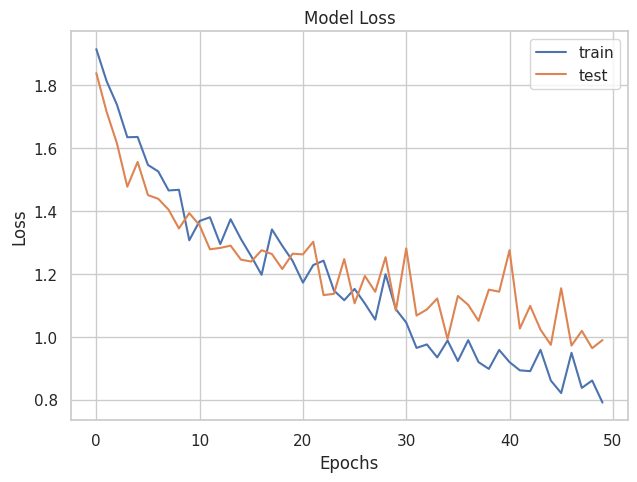

In [65]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

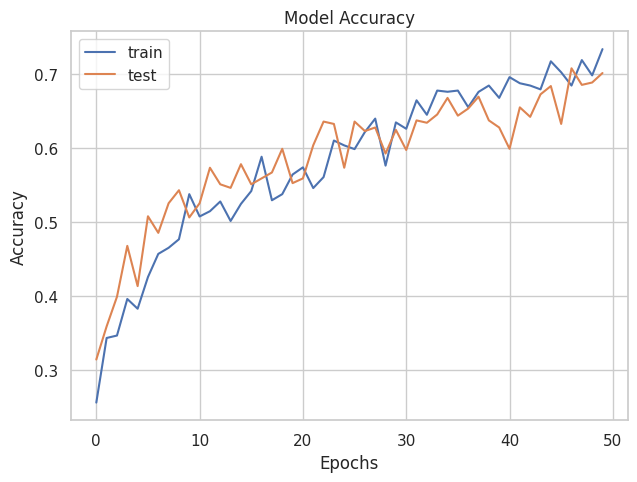

In [66]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [67]:
# getting predictions on val set.
pred=model.predict(test_images)
pred_digits=np.argmax(pred,axis=1)

20/20 [==============================] - 11s 526ms/step


In [69]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(test_labels)):
    if(np.argmax(test_labels[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(test_labels)):
    if(not np.argmax(test_labels[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

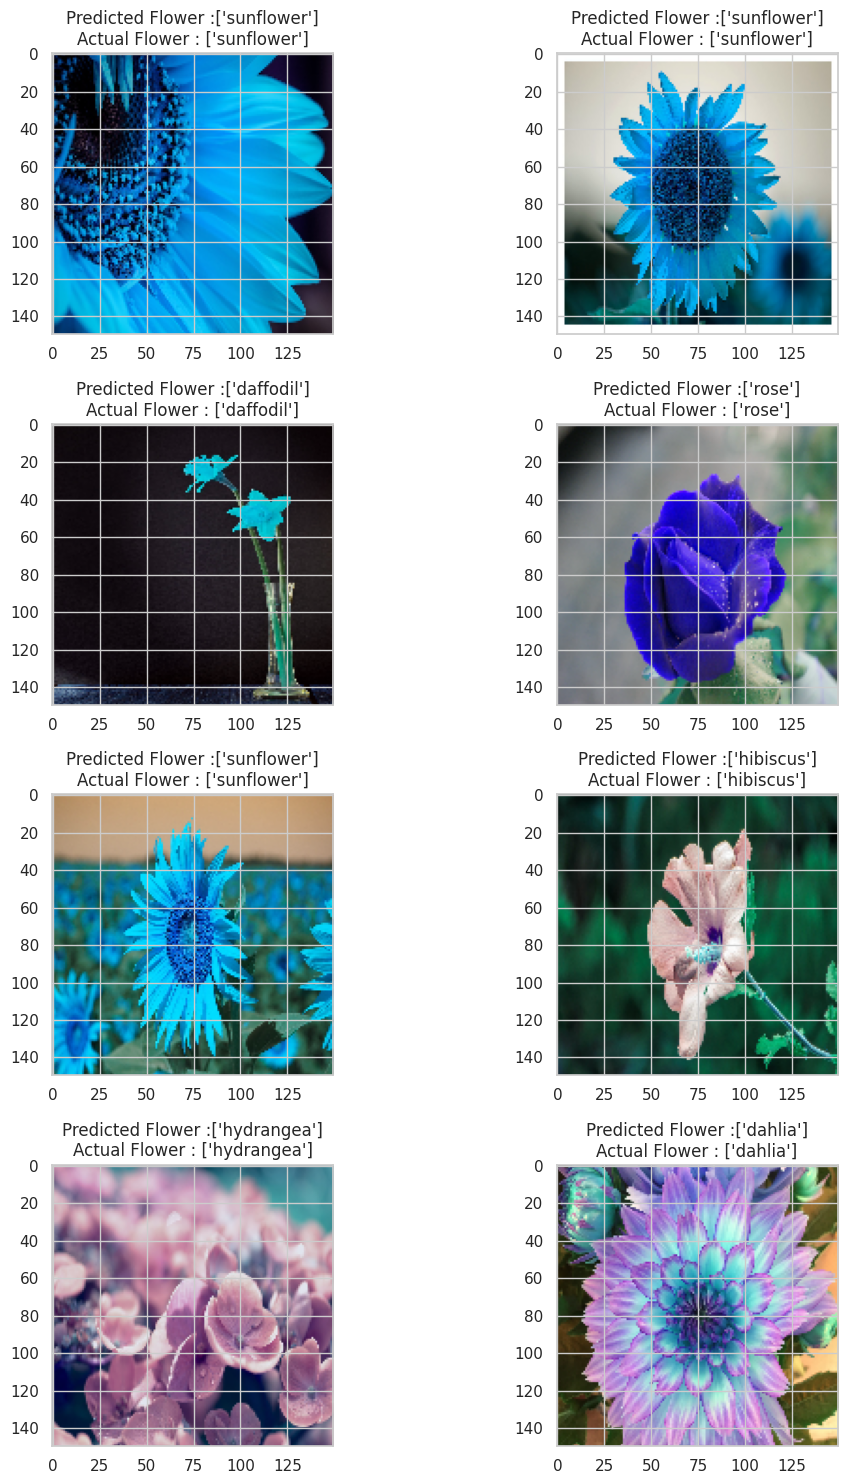

In [71]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(test_images[prop_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(labelEncoder.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([np.argmax(test_labels[prop_class[count]])])))
        plt.tight_layout()
        count+=1

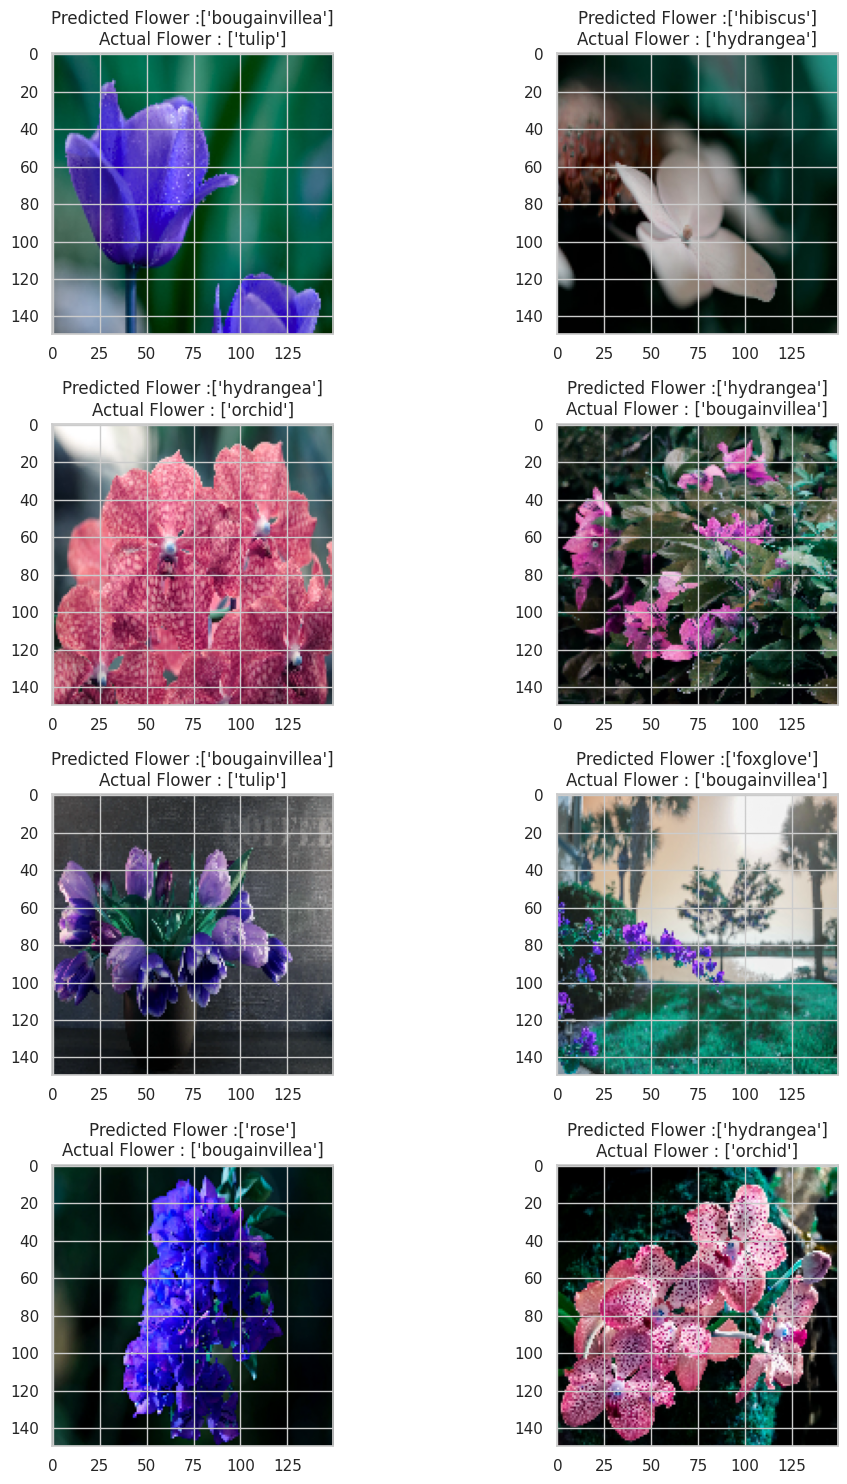

In [74]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(test_images[mis_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(labelEncoder.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([np.argmax(test_labels[mis_class[count]])])))
        plt.tight_layout()
        count+=1

In [79]:
predictions=model.predict(test_images)

20/20 [==============================] - 15s 750ms/step


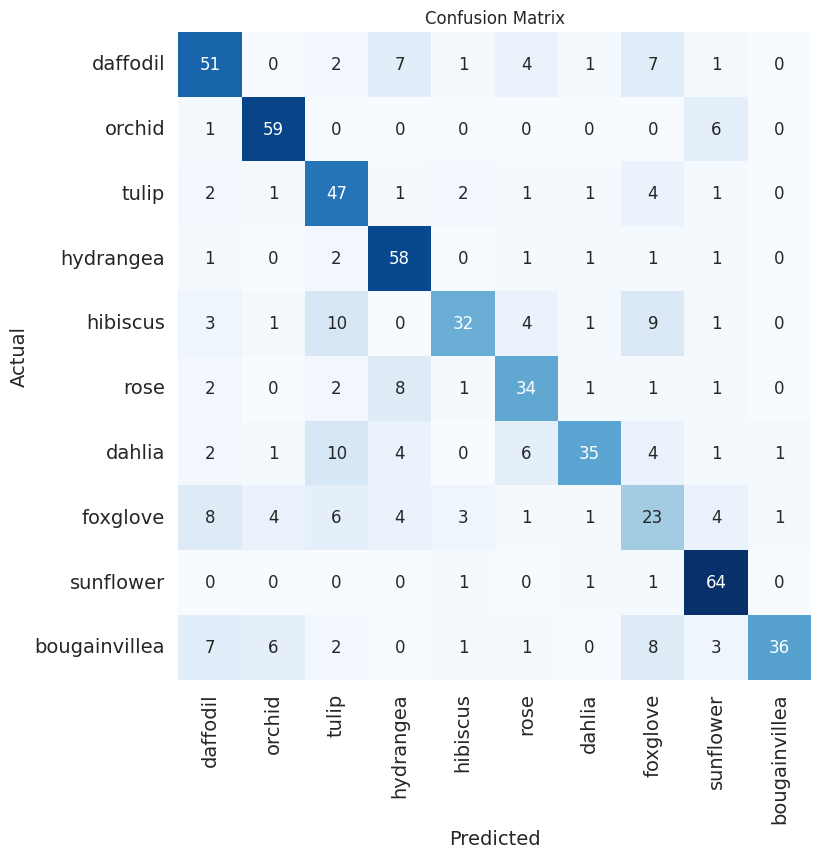

In [87]:
from sklearn.utils.multiclass import unique_labels
# Convert one-hot encoded labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)
predictions_indices = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels_indices, predictions_indices)

# Get class labels
classes = ['daffodil', 'orchid', 'tulip', 'hydrangea', 'hibiscus', 'rose', 'dahlia', 'foxglove', 'sunflower', 'bougainvillea']
class_count = len(classes)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)

sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(class_count) + .5, classes, rotation=90, fontsize=14)
plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix")

plt.show()

In [90]:
from sklearn.metrics import classification_report

print(classification_report(predictions_indices, test_labels_indices))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68        77
           1       0.89      0.82      0.86        72
           2       0.78      0.58      0.67        81
           3       0.89      0.71      0.79        82
           4       0.52      0.78      0.63        41
           5       0.68      0.65      0.67        52
           6       0.55      0.83      0.66        42
           7       0.42      0.40      0.41        58
           8       0.96      0.77      0.85        83
           9       0.56      0.95      0.71        38

    accuracy                           0.70       626
   macro avg       0.69      0.72      0.69       626
weighted avg       0.73      0.70      0.71       626

